In [1]:
%matplotlib inline
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
import pylab
pylab.rcParams['figure.figsize'] = (5.0*4.0/4.0, 4.0)
import numpy as np
from IPython.display import set_matplotlib_formats,display
set_matplotlib_formats('svg')
def plot_rectangular_domain(domain):
    from matplotlib import pyplot, collections
    cmap = pylab.get_cmap("hsv")
    lines = [[domain.x,(domain.x[0],domain.x[1]+domain.L[1])], 
             [(domain.x[0],domain.x[1]+domain.L[1]),(domain.x[0]+domain.L[0],domain.x[1]+domain.L[1])],
             [(domain.x[0]+domain.L[0],domain.x[1]+domain.L[1]),(domain.x[0]+domain.L[0],domain.x[1])],
             [(domain.x[0]+domain.L[0],domain.x[1]),domain.x]]
    lc = collections.LineCollection(lines,linewidths=3)
    fig, ax = pyplot.subplots()
    ax.add_collection(lc)
    ax.margins(0.1)
    ax.set_aspect('equal')
    pylab.savefig("rectangle.pdf")
def plot_pslg_domain(domain):
    from matplotlib import pyplot, collections
    lines = []
    cmap = pylab.get_cmap("hsv")
    c = []
    sF_max = float(max(domain.segmentFlags))
    for s,sF in zip(domain.segments,domain.segmentFlags):
        lines.append([domain.vertices[s[0]],domain.vertices[s[1]]])
        c.append(cmap(float(sF/sF_max)))
    lc = collections.LineCollection(lines,colors=c,linewidths=3)
    fig, ax = pyplot.subplots()
    ax.add_collection(lc)
    ax.margins(0.1)
    ax.set_aspect('equal')
    pylab.savefig("pslg.pdf")
def plot_plc_domain(domain,elev=0,azim=0):
    import mpl_toolkits.mplot3d as a3
    import matplotlib.colors as colors
    import pylab as pl
    from matplotlib import pyplot as plt
    ax = a3.Axes3D(pl.figure(),elev=elev,azim=azim)
    cmap = pylab.get_cmap("hsv")
    fN_max = float(max(domain.facetFlags))
    verts=[]
    c=[]
    for f,fN in zip(domain.facets,domain.facetFlags):
        verts.append([domain.vertices[vN] for vN in f[0]])
        c.append(cmap(fN/fN_max))
    ply = a3.art3d.Poly3DCollection(verts)
    ply.set_facecolors(c)
    ax.add_collection3d(ply)
    ax.margins(0.1,0.1,0.1)
    ax.set_aspect('equal')
    ax.set_xlim(domain.x[0],domain.L[0])
    ax.set_ylim(domain.x[1],domain.L[1])
    ax.set_zlim(domain.x[2],domain.L[2])
    pylab.savefig("plc.pdf")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#Domain Tutorial

The domain of the PDE is represented as an object. There are many useful types of domain defined in `proteus.Domain`.

In [2]:
from proteus import Domain

Let $\Omega = (0,1) \times (0,1)$. $\Omega$ can be defined as a `RectangularDomain`:

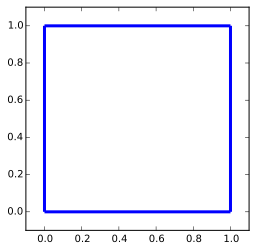

In [3]:
box = Domain.RectangularDomain(L=(1.0,1.0),x=(0.0,0.0),name="UnitSqure",units='m')
plot_rectangular_domain(box)

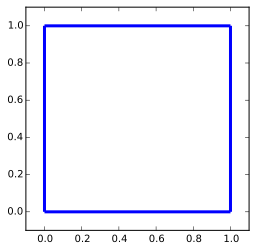

In [4]:
def f(Lx,Ly,box):
    box.L=(Lx,Ly)
    plot_rectangular_domain(box)
    return box
boxWidget = interactive(f,Lx=1.0,Ly=1.0,box=fixed(box))
display(boxWidget)

Real world problems typically require something more complex. A `PlanarStraightLineGraph` can be used to describe many two-dimensional domains. Note how we also can tag boundaries with an integer that partitions the boundary (used later for boundary condtions).

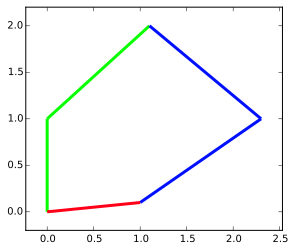

In [5]:
polygon = Domain.PlanarStraightLineGraphDomain(
vertices=[[0.0,0.0],[0.0,1.0],[1.1,2.0],[2.3,1.0],[1.0,0.1]],
segments    =[[0,1],[1,2],[2,3],[3,4],[4,0]],
segmentFlags=[ 1   , 1   ,2    ,2    ,3],
name="SomePolygon",
units='cm')
plot_pslg_domain(polygon)

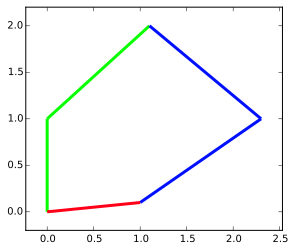

In [6]:
import copy
def g(xscale,yscale,polygon,polygonOriginal):
    new_vertices=[]
    for vi,v in enumerate(polygonOriginal.vertices):
        new_vertices.append([v[0]*xscale,v[1]*yscale])
    polygon = Domain.PlanarStraightLineGraphDomain(vertices=new_vertices,
                                                   segments    = polygonOriginal.segments,
                                                   segmentFlags= polygonOriginal.segmentFlags,
                                                   name="SomePolygon",
                                                   units='cm')
    plot_pslg_domain(polygon)
    return polygon
pslg_domain_editor = interactive(g,xscale=1.0,yscale=1.0,polygon=fixed(polygon),
                            polygonOriginal=fixed(copy.deepcopy(polygon)))
display(pslg_domain_editor)

A `PiecewiseLinearComplex` is a general three-dimensional domain type. Here we create one by extruding the previous 2D domain.

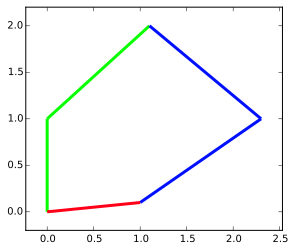

In [7]:
plot_pslg_domain(pslg_domain_editor.result)

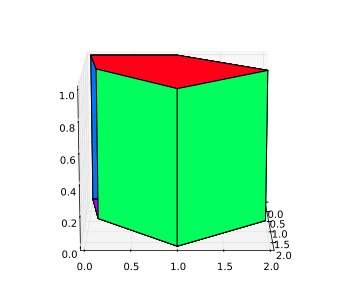

In [8]:
vertices3D = []
facets3D = []
facetFlags3D=[]
#extrude
nVertices2D=len(polygon.vertices)
maxFlag = max(polygon.segmentFlags)
for v in polygon.vertices: 
    vertices3D.append([v[0],v[1],0.0])
    facets3D.append([range(nVertices2D)])
    facetFlags3D.append(maxFlag+1)
for v in polygon.vertices:
    vertices3D.append([v[0],v[1],1.0])
    facets3D.append([range(nVertices2D,nVertices2D*2)])
    facetFlags3D.append(maxFlag+2)
nSegments2D  = len(polygon.segments)
for s,sN in zip(polygon.segments,polygon.segmentFlags):
    facets3D.append([[s[0],s[1],(s[1]+nSegments2D)%(2*nSegments2D),s[0]+nSegments2D]])
    facetFlags3D.append(sN)
polyhedron = Domain.PiecewiseLinearComplexDomain(
vertices=vertices3D,
facets=facets3D,
facetFlags=facetFlags3D)
plot_plc_domain(polyhedron,elev=15,azim=0)

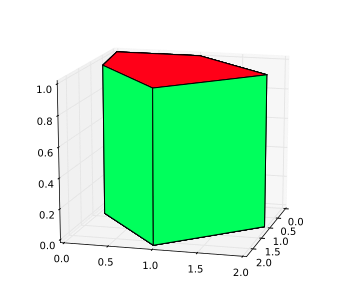

In [9]:
import copy
def edit_plc_domain(xscale=1.0,yscale=1.0,zscale=1.0,
                    elev=15,azim=15,
                    plc=polyhedron,plcOriginal=copy.deepcopy(polyhedron)):
    new_vertices=[]
    for vi,v in enumerate(plcOriginal.vertices):
        new_vertices.append([v[0]*xscale,v[1]*yscale,v[2]*zscale])
    plc = Domain.PiecewiseLinearComplexDomain(vertices=new_vertices,
                                              facets=plc.facets,
                                              facetFlags=plc.facetFlags)
    plot_plc_domain(plc,elev,azim)
    return plc
plc_domain_editor = interactive(edit_plc_domain,
                              xscale=(0.1,10.0),
                              yscale=(0.1,10.0),
                              zscale=(0.1,10.0),
                              elev=(-90,90,10),azim=(-180,180,10),
                              plc=fixed(polyhedron),
                              plcOriginal=fixed(copy.deepcopy(polyhedron)))
display(plc_domain_editor)

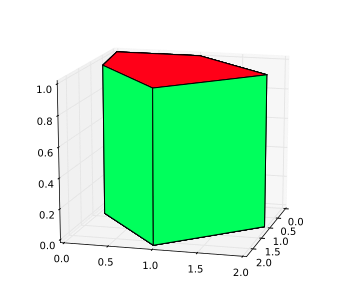

In [10]:
plot_plc_domain(plc_domain_editor.result,15,15)